#### EDA

features

CAN BE COMPUTED FROM REQUEST DATA ONLY
- request_size
- response_code
- response_code_group
- bad_null_data_flags
- sql_inj
- Cross Site Scripting (XSS)
- rce
- path traversal
- dos/ddos
- remote file inclusion
- os file access
- phishing
- fuzzing
- Local File Inclusion (LFI)
- Remote File Inclusion (RFI)
- PHP Code Injection
- Java Code Injection
- Shellshock
- Unix/Windows Shell Injection
- Session Fixation
- Scripting/Scanner/Bot Detection
- Metadata/Error Leakages

CAN BE COMPUTED WITH HISTORICAL DATA
- ratio response_code
- num ips with ua
- num uas with ip
- 

Use signatures for data markup then build model on non-signature features to generalize for new attacks -- profit

#### ToDo  
-request validation  
-tests and how to start with docker  
-EDA clustering for more insights  
-подогнать апи под спецификацию -как использовать openapi specs? какие нужны доработки?  
-отображение результатов в дэшборде  
-CI/CD github  
-model tuning. features

+единоразовая загрузка модели  
+README (software versions, how to start, how to get results)  
+навести порядок в ноутбуке  
+сериализация модели (см sklearn persistence)  
+короче пилим сервис с базовой моделью, потом допиливаем модель и pipeline  
+вынести вспомогательный код в модуль  
+получение данных из запроса  
+преобразование в датафрейм  
+инференс  
+формирование Джейсона для ответа  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import hdbscan
import json
import pickle
pd.set_option('display.max_rows', 2000)

In [6]:
d = pd.read_csv("project/data/part_10.csv")

In [8]:
def feature_engineering(d):
    #### clean and prepare data
    # CLIENT IP
    d["CLIENT_IP"].fillna("NONE", inplace=True)

    def ip_str(v, ip_pattern):
        return 1 if re.match(ip_pattern, v) else 0

    ip_pattern = "^((25[0-5]|(2[0-4]|1\d|[1-9]|)\d)(\.(?!$)|$)){4}$"
    d["_ipv4"] = d["CLIENT_IP"].apply(lambda v: ip_str(v, ip_pattern))
    ip_pattern = "^\s*((([0-9A-Fa-f]{1,4}:){7}([0-9A-Fa-f]{1,4}|:))|(([0-9A-Fa-f]{1,4}:){6}(:[0-9A-Fa-f]{1,4}|((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3})|:))|(([0-9A-Fa-f]{1,4}:){5}(((:[0-9A-Fa-f]{1,4}){1,2})|:((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3})|:))|(([0-9A-Fa-f]{1,4}:){4}(((:[0-9A-Fa-f]{1,4}){1,3})|((:[0-9A-Fa-f]{1,4})?:((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3}))|:))|(([0-9A-Fa-f]{1,4}:){3}(((:[0-9A-Fa-f]{1,4}){1,4})|((:[0-9A-Fa-f]{1,4}){0,2}:((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3}))|:))|(([0-9A-Fa-f]{1,4}:){2}(((:[0-9A-Fa-f]{1,4}){1,5})|((:[0-9A-Fa-f]{1,4}){0,3}:((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3}))|:))|(([0-9A-Fa-f]{1,4}:){1}(((:[0-9A-Fa-f]{1,4}){1,6})|((:[0-9A-Fa-f]{1,4}){0,4}:((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3}))|:))|(:(((:[0-9A-Fa-f]{1,4}){1,7})|((:[0-9A-Fa-f]{1,4}){0,5}:((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])(\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])){3}))|:)))(%.+)?\s*$"
    d["_ipv6"] = d["CLIENT_IP"].apply(lambda v: ip_str(v, ip_pattern))


    # CLIENT_USERAGENT
    d["CLIENT_USERAGENT"].fillna("NONE", inplace=True)
    d["_useragent_len"] = d["CLIENT_USERAGENT"].apply(len)

    # REQUEST_SIZE
    d["_req_size_none"] = 1*d["REQUEST_SIZE"].isna()
    d["_req_size_string"] = 1*d["REQUEST_SIZE"].apply(lambda v: len(str(v)) > 10)

    d["REQUEST_SIZE"].fillna("0", inplace=True)
    def reqsize2number(s):
        if isinstance(s, str) and len(s) > 10:
            s = "0"
        return int(s)

    d["REQUEST_SIZE"] = d["REQUEST_SIZE"].apply(reqsize2number)

    # RESPONSE_CODE
    d["_resp_code_none"] = 1*d["RESPONSE_CODE"].isna()
    d["RESPONSE_CODE"].fillna("0")
    def code2int(s):
        if s is np.NAN:
            s = "0"
        elif len(str(s)) > 3:
            s = "0"
        return int(s)

    def code2grp(v):
        return v//100*100

    d["RESPONSE_CODE"] = d["RESPONSE_CODE"].apply(code2int)
    d["_resp_code_grp"] = d["RESPONSE_CODE"].apply(code2grp)

    d["MATCHED_VARIABLE_SRC"].fillna("NONE", inplace=True)
    d["MATCHED_VARIABLE_NAME"].fillna("NONE", inplace=True)

    # MATCHED_VARIABLE_VALUE
    d["MATCHED_VARIABLE_VALUE"].fillna("NONE", inplace=True)
    def susp_commands(s, commands):
        s = s.lower()
        susp = 0
        for temp in commands:
            if temp in s:
                susp = 1
                break
        return susp

    sql_commands = ['select', 'union', 'and ', 'or ']
    d["_matched_variable_value_sql"] = 1*d["MATCHED_VARIABLE_VALUE"].apply(lambda v: susp_commands(v, sql_commands))

    rce_commands = ['ls -la', 'echo', 'exec', 'eval', 'print', 'factor', '<script', ':usb', 'response.write']
    # %2525252526page%2525253D3%25252526page%2525253
    d["_matched_variable_value_rce"] = 1*d["MATCHED_VARIABLE_VALUE"].apply(lambda v: susp_commands(v, rce_commands))

    path_commands = ['../', '%5c', '0xf2', '%u2216']
    d["_matched_variable_value_path"] = 1*d["MATCHED_VARIABLE_VALUE"].apply(lambda v: susp_commands(v, path_commands))
    
    return d

d = feature_engineering(d)

# target variable for multiclass classification
# 0 - no attack
# 1 - sql injection
# 2 - rce
# 3 - path traversal

def target(v):
    if v["_matched_variable_value_sql"] == 1:
        return 1
    elif v["_matched_variable_value_rce"] == 1:
        return 2
    elif v["_matched_variable_value_path"] == 1:
        return 3
    else:
        return 0


d["Y"] = d.apply(target, axis=1)

In [9]:
d.columns

Index(['CLIENT_IP', 'CLIENT_USERAGENT', 'REQUEST_SIZE', 'RESPONSE_CODE',
       'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE', 'EVENT_ID', '_ipv4', '_ipv6',
       '_useragent_len', '_req_size_none', '_req_size_string',
       '_resp_code_none', '_resp_code_grp', '_matched_variable_value_sql',
       '_matched_variable_value_rce', '_matched_variable_value_path', 'Y'],
      dtype='object')

In [10]:
d.shape

(57845, 19)

#### model

In [11]:
## model multiclass classification
# sklearn random_forest

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score


col = [
    'REQUEST_SIZE',
    'RESPONSE_CODE',
    '_ipv4',
    '_ipv6',
    '_useragent_len',
    '_req_size_none',
    '_req_size_string',
    '_resp_code_none',
    '_resp_code_grp',
    #'_matched_variable_value_sql',
    #'_matched_variable_value_rce',
    #'_matched_variable_value_path',
]
X = d[col]
Y = d["Y"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.33,
                                                    random_state=42)

model = rfc(n_estimators=42)
model = model.fit(X_train, Y_train)

pickle.dump(model, open("project/ml_models/rfc_42.pickle", "wb"))

p = model.predict(X_test)

In [12]:
cm = confusion_matrix(Y_test, p)

In [13]:
cm

array([[16839,   164,    82,    82],
       [  250,   722,     9,    15],
       [   87,    17,   310,     5],
       [  172,     9,     6,   320]])

In [ ]:
фичи работают, но есть куда улучшать

In [14]:
np.sum(cm.trace())/np.sum(cm)

0.952957200481953

In [483]:
import time

t0 = time.time()
model.predict(X_test.head(1000))
print(time.time()-t0)

0.21311068534851074


In [474]:
1M per 15 sec

1.4999999999999999e-05

In [ ]:
curl -X 'POST' 'http://127.0.0.1:80/predict' -H 'accept: application/json' -H 'Content-Type: application/json' -d '[{"data": "{\"CLIENT_IP\": \"188.138.92.55\", \"CLIENT_USERAGENT\": NaN, \"REQUEST_SIZE\": 166, \"RESPONSE_CODE\": 404, \"MATCHED_VARIABLE_SRC\": \"REQUEST_URI\", \"MATCHED_VARIABLE_NAME\": NaN, \"MATCHED_VARIABLE_VALUE\": \"//tmp/20160925122692indo.php.vob\", \"EVENT_ID\": \"AVdhXFgVq1Ppo9zF5Fxu\"}"}, {"data": "{\"CLIENT_IP\": \"93.158.215.131\", \"CLIENT_USERAGENT\": \"Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) Gecko/20100101 Firefox/45.0\", \"REQUEST_SIZE\": 431, \"RESPONSE_CODE\": 302, \"MATCHED_VARIABLE_SRC\": \"REQUEST_GET_ARGS\", \"MATCHED_VARIABLE_NAME\": \"url\", \"MATCHED_VARIABLE_VALUE\": \"http://www.galitsios.gr/?option=com_k2\", \"EVENT_ID\": \"AVdcJmIIq1Ppo9zF2YIp\"}"}]'

#### data from request

In [15]:
import json
# data from request
#data = '''[{"data": "{\"CLIENT_IP\": \"188.138.92.55\", \"CLIENT_USERAGENT\": NaN, \"REQUEST_SIZE\": 166, \"RESPONSE_CODE\": 404, \"MATCHED_VARIABLE_SRC\": \"REQUEST_URI\", \"MATCHED_VARIABLE_NAME\": NaN, \"MATCHED_VARIABLE_VALUE\": \"//tmp/20160925122692indo.php.vob\", \"EVENT_ID\": \"AVdhXFgVq1Ppo9zF5Fxu\"}"}, {"data": "{\"CLIENT_IP\": \"93.158.215.131\", \"CLIENT_USERAGENT\": \"Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) Gecko/20100101 Firefox/45.0\", \"REQUEST_SIZE\": 431, \"RESPONSE_CODE\": 302, \"MATCHED_VARIABLE_SRC\": \"REQUEST_GET_ARGS\", \"MATCHED_VARIABLE_NAME\": \"url\", \"MATCHED_VARIABLE_VALUE\": \"http://www.galitsios.gr/?option=com_k2\", \"EVENT_ID\": \"AVdcJmIIq1Ppo9zF2YIp\"}"}]'''
data = '''[{\'data\': \'{"CLIENT_IP": "188.138.92.55", "CLIENT_USERAGENT": NaN, "REQUEST_SIZE": 166, "RESPONSE_CODE": 404, "MATCHED_VARIABLE_SRC": "REQUEST_URI", "MATCHED_VARIABLE_NAME": NaN, "MATCHED_VARIABLE_VALUE": "//tmp/20160925122692indo.php.vob", "EVENT_ID": "AVdhXFgVq1Ppo9zF5Fxu"}\'}, {\'data\': \'{"CLIENT_IP": "93.158.215.131", "CLIENT_USERAGENT": "Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) Gecko/20100101 Firefox/45.0", "REQUEST_SIZE": 431, "RESPONSE_CODE": 302, "MATCHED_VARIABLE_SRC": "REQUEST_GET_ARGS", "MATCHED_VARIABLE_NAME": "url", "MATCHED_VARIABLE_VALUE": "http://www.galitsios.gr/?option=com_k2", "EVENT_ID": "AVdcJmIIq1Ppo9zF2YIp"}\'}]'''

data = data.replace("'", '"')
data = data.replace('"{', '{')
data = data.replace('}"}', '}}')
data = json.loads(data)
#data = pd.json_normalize(data[0])
data = pd.json_normalize(data)
data.columns = [v.split('.')[1] for v in data.columns]

# prepare for inference
data = feature_engineering(data)

# inference
col = [
    'REQUEST_SIZE',
    'RESPONSE_CODE',
    '_ipv4',
    '_ipv6',
    '_useragent_len',
    '_req_size_none',
    '_req_size_string',
    '_resp_code_none',
    '_resp_code_grp',
]
data['p'] = model.predict(data[col])

# service response
resp = []
r = {}
for i in range(len(data)):
    r['EVENT_ID'] = data['EVENT_ID'][i]
    r['LABEL_PRED'] = str(data['p'][i])
    resp.append(r)

json.dumps(resp)

'[{"EVENT_ID": "AVdcJmIIq1Ppo9zF2YIp", "LABEL_PRED": "0"}, {"EVENT_ID": "AVdcJmIIq1Ppo9zF2YIp", "LABEL_PRED": "0"}]'

In [467]:
X_test.head(1)

,REQUEST_SIZE,RESPONSE_CODE,_ipv4,_ipv6,_useragent_len,_req_size_none,_req_size_string,_resp_code_none,_resp_code_grp
6020,303,200,1,0,39,0,0,0,200


In [425]:
p = model.predict(d[col])

In [426]:
[sum(p==v) for v in range(4)]

[52116, 3028, 1330, 1371]

In [319]:
d.head(1)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,_bad_ip,_req_size_none,_req_size_string,_resp_code_none,_resp_code_grp,_matched_variable_value_susp
0,188.138.92.55,NONE,166,404,REQUEST_URI,NONE,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0,0,0,400,0


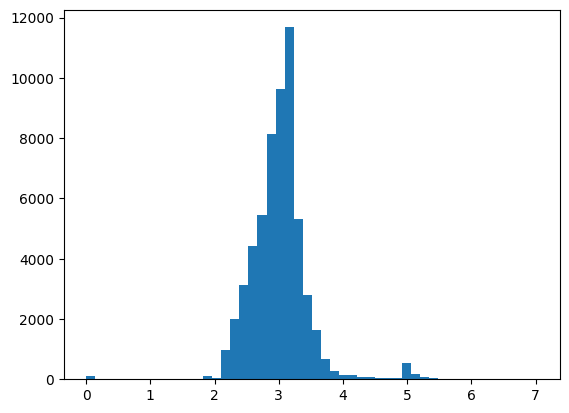

In [253]:
plt.hist(np.log10(d['REQUEST_SIZE']+1), bins=50)
plt.show()

In [239]:
d.groupby(['_resp_code_grp']).size().sort_values(ascending=False)

_resp_code_grp
200    25981
400    21845
300     8265
500     1638
0        116
dtype: int64

In [200]:
d.groupby(["MATCHED_VARIABLE_SRC"]).size().sort_values(ascending=False)

MATCHED_VARIABLE_SRC
REQUEST_GET_ARGS                    20812
REQUEST_COOKIES                      9303
REQUEST_HEADERS                      4930
REQUEST_PATH                         4011
REQUEST_ARGS                         3729
RESPONSE_HEADERS                     3364
REQUEST_POST_ARGS                    3304
REQUEST_URI                          3143
REQUEST_XML                          1959
REQUEST_METHOD\';\'REQUEST_CONTE      812
REQUEST_URI\';\'REQUEST_ARGS          666
REQUEST_ARGS_KEYS                     639
REQUEST_JSON                          587
REQUEST_METHOD\';\'REQUEST_HEADE      227
CLIENT_USERAGENT                      133
CLIENT_SESSION_ID                      42
REQUEST_QUERY                          35
RESPONSE_BODY                          22
REQUEST_CONTENT_TYPE                    6
REQUEST_FILES                           5
CLIENT_IP                               1
dtype: int64

In [203]:
d.groupby(["MATCHED_VARIABLE_NAME"]).size().sort_values(ascending=False).head(20)

MATCHED_VARIABLE_NAME
REQUEST_GET_ARGS._                    11165
REQUEST_COOKIES.LtpaToken2             3945
REQUEST_PATH                           3821
REQUEST_COOKIES.User-cn                2444
action                                 2378
REQUEST_HEADERS.User-Agent             1783
url                                    1350
REQUEST_GET_ARGS.rid                   1315
RESPONSE_HEADERS.AN-X-Request-Uuid     1024
REQUEST_POST_ARGS.rid                   987
REQUEST_GET_ARGS.id                     911
REQUEST_HEADERS.If-Modified-Since       585
id                                      523
RESPONSE_HEADERS.Date                   514
REQUEST_COOKIES.icu                     454
REQUEST_HEADERS.X-csrftoken             426
REQUEST_HEADERS.If-None-Match           416
anj                                     378
REQUEST_GET_ARGS.s                      374
X-Requested-With\';\'CSRF_TOKEN         333
dtype: int64

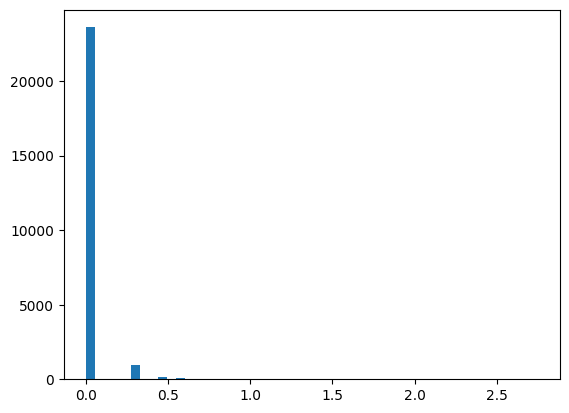

In [245]:
d.groupby(['CLIENT_IP'])['CLIENT_USERAGENT'].nunique().sort_values(ascending=False)

In [133]:
d[d['EVENT_ID'].isin(["kFdQHGQB5cBXmMW17aUi"])]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,_bad_ip
275,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6141,204,REQUEST_COOKIES,REQUEST_COOKIES.taboola_upci,CIPakOu8KhIPFQCgjkQdqLSdQiXRZltDGPn2nAMY-pHGAx...,kFdQHGQB5cBXmMW17aUi,0
3961,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6141,204,REQUEST_COOKIES,REQUEST_COOKIES.stpt,"\""liveintent-network!-#@1518519641162,thetrade...",kFdQHGQB5cBXmMW17aUi,0
14037,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6141,204,REQUEST_POST_ARGS,REQUEST_POST_ARGS.ri,23c2a01dceb57cbe3ad1099930acef7a,kFdQHGQB5cBXmMW17aUi,0
46451,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,6141,204,REQUEST_JSON,REQUEST_JSON.tii,~~V1~~-626303264852574562~~jOv_yDG_OKLW8RLY8OK...,kFdQHGQB5cBXmMW17aUi,0


In [134]:
d['MATCHED_VARIABLE_VALUE'].iloc[3961]

'\\"liveintent-network!-#@1518519641162,thetradedesk-network!-#@1518519641162,bombora!-#@1519119362493,connexity!-#@1518519641162,skimlinks!-#@1518067762197,google-network!-#@1518519641162,liveramp!-#@1518519641162,appnexus!-#@1518519641162,tapad!-#@1517915141162,bluekai!-#@1518519641162,storygize-network!-#@1518519641162,neustar!-#@1518519641162,crosswise!-#@1518519641162,drawbridge!-#@1518519641162\\"'

In [ ]:
#### clustering

In [269]:
#import seaborn as sns
import sklearn.cluster as cluster
import seaborn as sns
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwgs = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [255]:
d.columns

Index(['CLIENT_IP', 'CLIENT_USERAGENT', 'REQUEST_SIZE', 'RESPONSE_CODE',
       'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE', 'EVENT_ID', '_bad_ip', '_req_size_none',
       '_req_size_string', '_resp_code_none', '_resp_code_grp'],
      dtype='object')

In [257]:
col = ['REQUEST_SIZE', '_resp_code_grp']


,REQUEST_SIZE,_resp_code_grp
0,166,400
1,431,300
2,395,400
3,387,300
4,1733,400
...,...,...
57840,2402,300
57841,922,400
57842,1453,400
57843,1550,200


In [284]:
d.columns

Index(['CLIENT_IP', 'CLIENT_USERAGENT', 'REQUEST_SIZE', 'RESPONSE_CODE',
       'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE', 'EVENT_ID', '_bad_ip', '_req_size_none',
       '_req_size_string', '_resp_code_none', '_resp_code_grp'],
      dtype='object')

In [320]:
col = ['REQUEST_SIZE', 'RESPONSE_CODE', '_bad_ip', '_req_size_none',
       '_req_size_string', '_resp_code_none', '_resp_code_grp', '_matched_variable_value_susp']

db = cluster.DBSCAN(eps=100, min_samples=50).fit(np.array(d[col]))
labels = db.labels_

d["cluster"] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [321]:
n_clusters_, n_noise_

(10, 2533)

In [314]:
from collections import Counter
cnt = Counter(labels)
dict(cnt)

{0: 21346,
 1: 7845,
 -1: 2533,
 2: 24404,
 3: 1238,
 6: 62,
 9: 50,
 4: 116,
 8: 27,
 5: 174,
 7: 50}

In [315]:
d[d['cluster'].isin([0])].head(100)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,_bad_ip,_req_size_none,_req_size_string,_resp_code_none,_resp_code_grp,cluster
0,188.138.92.55,NONE,166,404,REQUEST_URI,NONE,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu,0,0,0,0,400,0
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,NONE,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U,0,0,0,0,400,0
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp,0,0,0,0,400,0
5,79.183.87.247,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,682,404,REQUEST_HEADERS,REQUEST_HEADERS.User-Agent,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,nFzwHGQB5cBXmMW1y_TD,0,0,0,0,400,0
7,77.72.142.170,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,763,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,214296569,97JpJGQB5cBXmMW1WqBh,0,0,0,0,400,0
9,83.246.141.54,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,840,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,51660445,g4RdIGQB5cBXmMW10nGg,0,0,0,0,400,0
14,176.112.234.231,Mozilla/5.0 (Linux; Android 7.0; SAMSUNG SM-G5...,993,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516570326076,7r1uJWQB5cBXmMW1b2ht,0,0,0,0,400,0
16,109.252.85.81,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,772,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516464016113,hZSlIWQB5cBXmMW1QRCA,0,0,0,0,400,0
19,83.139.147.32,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,1699,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516357230209,4nQaH2QB5cBXmMW1DeNf,0,0,0,0,400,0
22,217.66.154.77,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_3 like...,1729,404,REQUEST_COOKIES,REQUEST_COOKIES.User-cn,Василий Глуховской,ZlGKG2QB5cBXmMW1oDEh,0,0,0,0,400,0
